<a href="https://colab.research.google.com/github/idiftech2010/Machine-Learning-Models-for-NIDS/blob/main/Machine_Learning_Models_for_Network_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload files manually
uploaded = files.upload()


Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set.csv
Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv


In [ ]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv("UNSW_NB15_training-set.csv")
df_test = pd.read_csv("UNSW_NB15_testing-set.csv")

# Display basic info
print("Training Set Shape:", df_train.shape)
print("Testing Set Shape:", df_test.shape)

# Show first few rows
df_train.head()


Training Set Shape: (175341, 45)
Testing Set Shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
from sklearn.preprocessing import StandardScaler

# Drop the 'id' column if it exists
df_train.drop(columns=['id'], errors='ignore', inplace=True)
df_test.drop(columns=['id'], errors='ignore', inplace=True)

# Identify categorical and numerical columns
categorical_features = ['proto', 'service', 'state', 'attack_cat']
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features + ['label']]

# One-Hot Encode categorical features
df_train_encoded = pd.get_dummies(df_train, columns=categorical_features)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_features)

# Align test set columns with training set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

# Standardize numerical features
scaler = StandardScaler()
df_train_encoded[numerical_features] = scaler.fit_transform(df_train_encoded[numerical_features])
df_test_encoded[numerical_features] = scaler.transform(df_test_encoded[numerical_features])

# Verify preprocessing
print("Preprocessed Training Set Shape:", df_train_encoded.shape)
print("Preprocessed Testing Set Shape:", df_test_encoded.shape)

df_train_encoded.head()


Preprocessed Training Set Shape: (175341, 205)
Preprocessed Testing Set Shape: (82332, 205)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat_Analysis,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,False,False,False,False,False,False,True,False,False,False
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,False,False,False,False,False,False,True,False,False,False
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,False,False,False,False,False,False,True,False,False,False
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,False,False,False,False,False,False,True,False,False,False
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
from sklearn.model_selection import train_test_split

# Define feature matrix (X) and target variable (y)
X = df_train_encoded.drop(columns=['label'])
y = df_train_encoded['label']

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify split
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Validation Set Shape:", X_val.shape, y_val.shape)


Training Set Shape: (140272, 204) (140272,)
Validation Set Shape: (35069, 204) (35069,)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 20 most relevant features using ANOVA F-test
k_best = SelectKBest(score_func=f_classif, k=20)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_val_selected = k_best.transform(X_val)

# Get selected feature names
selected_feature_names = X.columns[k_best.get_support()].tolist()
print("Selected Features:", selected_feature_names)

# Verify shape after feature selection
print("Reduced Training Set Shape:", X_train_selected.shape)
print("Reduced Validation Set Shape:", X_val_selected.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [192 193 200] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected Features: ['rate', 'sttl', 'dload', 'swin', 'stcpb', 'dtcpb', 'dwin', 'dmean', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_src_ltm', 'proto_tcp', 'state_CON', 'state_FIN', 'state_INT', 'attack_cat_Exploits', 'attack_cat_Generic', 'attack_cat_Normal']
Reduced Training Set Shape: (140272, 20)
Reduced Validation Set Shape: (35069, 20)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train model
rf_model.fit(X_train_selected, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_val_selected)

# Evaluate performance
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_report = classification_report(y_val, y_pred_rf)

print("Random Forest Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)


Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11200
           1       1.00      1.00      1.00     23869

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid (same as before)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search (n_iter=10 for speed)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                   param_dist, n_iter=10, cv=3, scoring='accuracy',
                                   n_jobs=-1, verbose=2, random_state=42)

# Fit model
random_search.fit(X_train_selected, y_train)

# Best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate optimized model
best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_val_selected)
best_rf_accuracy = accuracy_score(y_val, y_pred_best_rf)
best_rf_report = classification_report(y_val, y_pred_best_rf)

print("Optimized Random Forest Accuracy:", best_rf_accuracy)
print("Classification Report:\n", best_rf_report)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Optimized Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11200
           1       1.00      1.00      1.00     23869

    accuracy                           1.00     35069
   macro avg       1.00      1.00      1.00     35069
weighted avg       1.00      1.00      1.00     35069



In [ ]:
import pandas as pd

# Assuming X_val_selected was originally derived from a DataFrame
feature_names = pd.DataFrame(X_val_selected).columns
feature_names


RangeIndex(start=0, stop=20, step=1)

In [ ]:
feature_names = X_train.columns  # or X_test.columns if applicable
feature_names


Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=204)

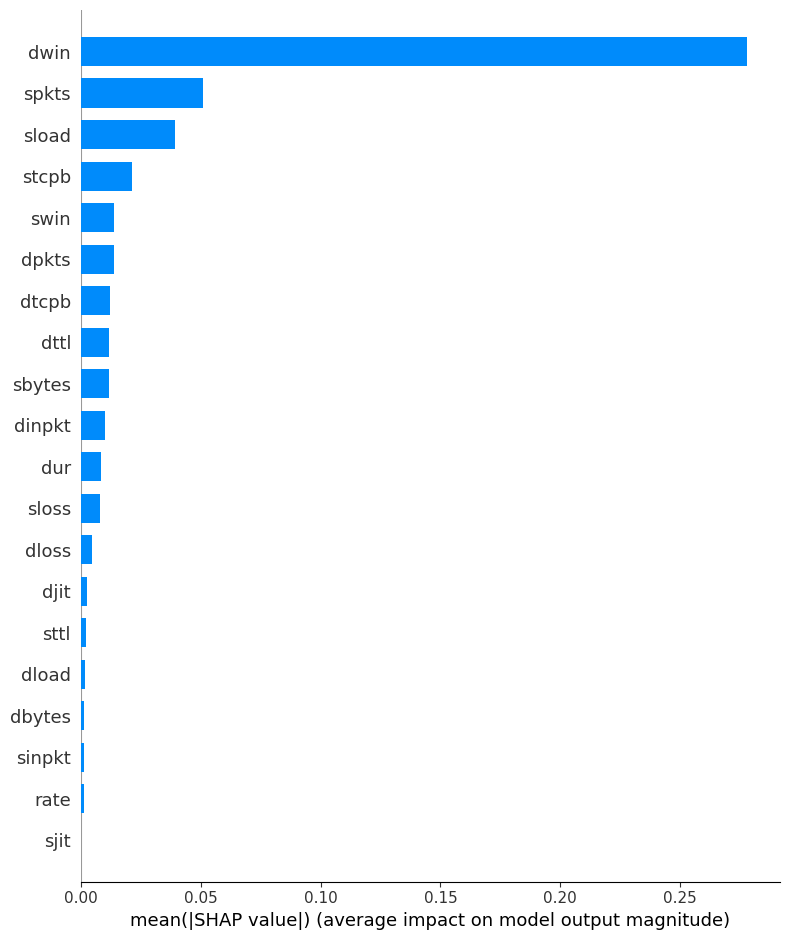

In [ ]:
# Assuming 'X_train' was the original DataFrame before feature selection
feature_names = X_train.columns[:X_train_selected.shape[1]]

shap.summary_plot(shap_values_class, X_val_selected, plot_type="bar", feature_names=feature_names)


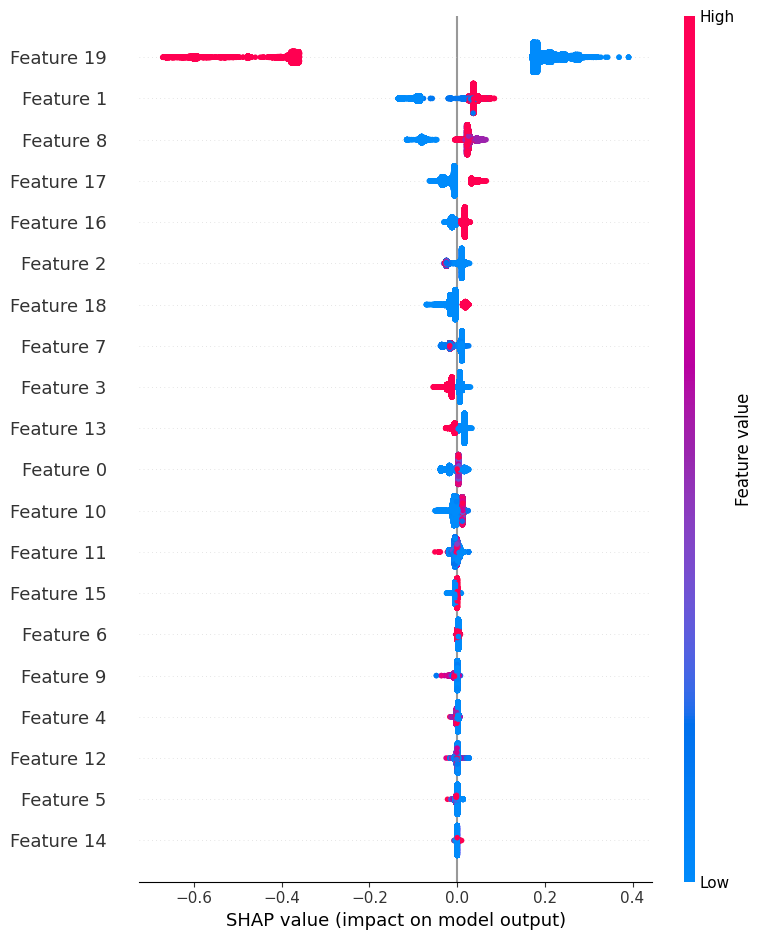

In [ ]:
shap.summary_plot(shap_values_class, X_val_selected)


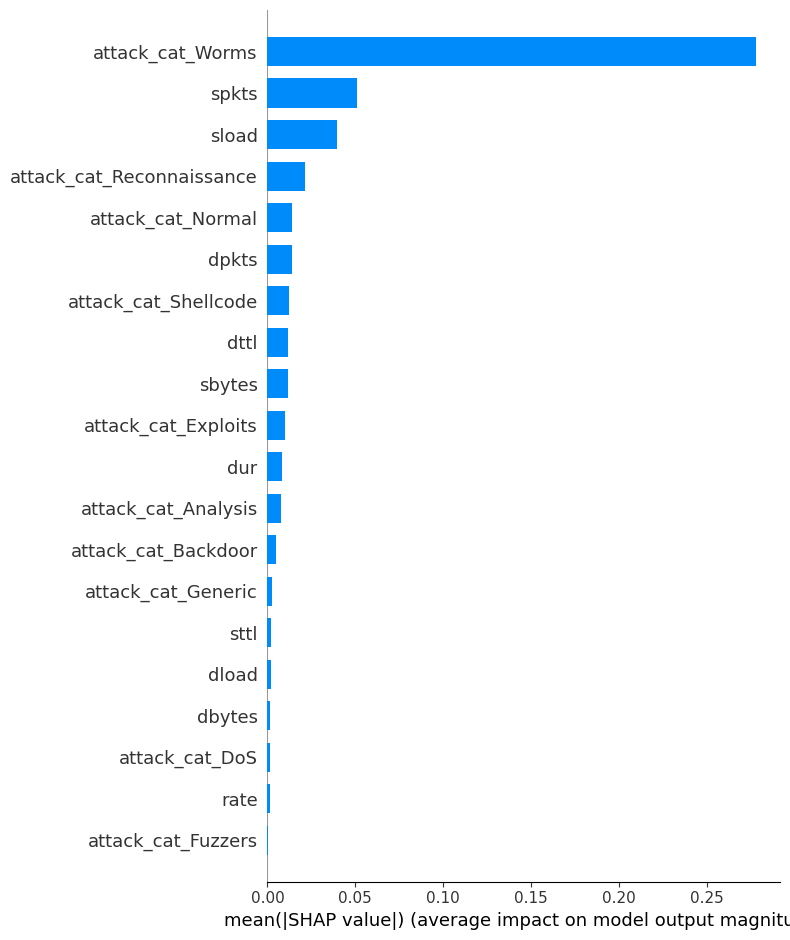

In [ ]:
import pandas as pd

# Ensure feature names are correctly assigned
feature_names = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
                 'sload', 'dload', 'attack_cat_Analysis', 'attack_cat_Backdoor',
                 'attack_cat_DoS', 'attack_cat_Exploits', 'attack_cat_Fuzzers',
                 'attack_cat_Generic', 'attack_cat_Normal', 'attack_cat_Reconnaissance',
                 'attack_cat_Shellcode', 'attack_cat_Worms']

# Convert NumPy array to DataFrame
X_val_selected_df = pd.DataFrame(X_val_selected, columns=feature_names)

# Generate SHAP plot with feature names
shap.summary_plot(shap_values_class, X_val_selected_df, plot_type="bar", feature_names=feature_names)


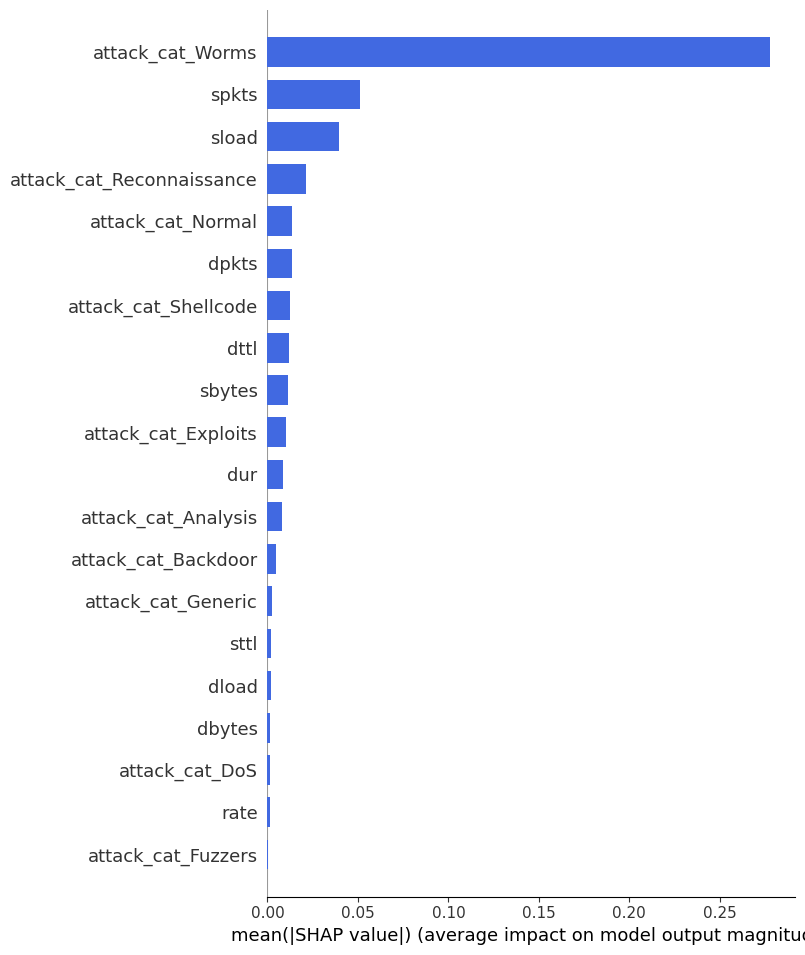

In [ ]:
import shap
import matplotlib.pyplot as plt

# Set a larger font size for readability
plt.rcParams.update({'font.size': 5})

# Generate SHAP summary plot with improved layout
shap.summary_plot(
    shap_values_class,
    X_val_selected,
    plot_type="bar",
    feature_names=feature_names,
    color='royalblue'  # Custom color for bars
)


In [ ]:
print(shap_values.shape)  # Check SHAP values shape
print(X_train_selected.shape)  # Check feature matrix shape


(35069, 20, 2)
(140272, 20)


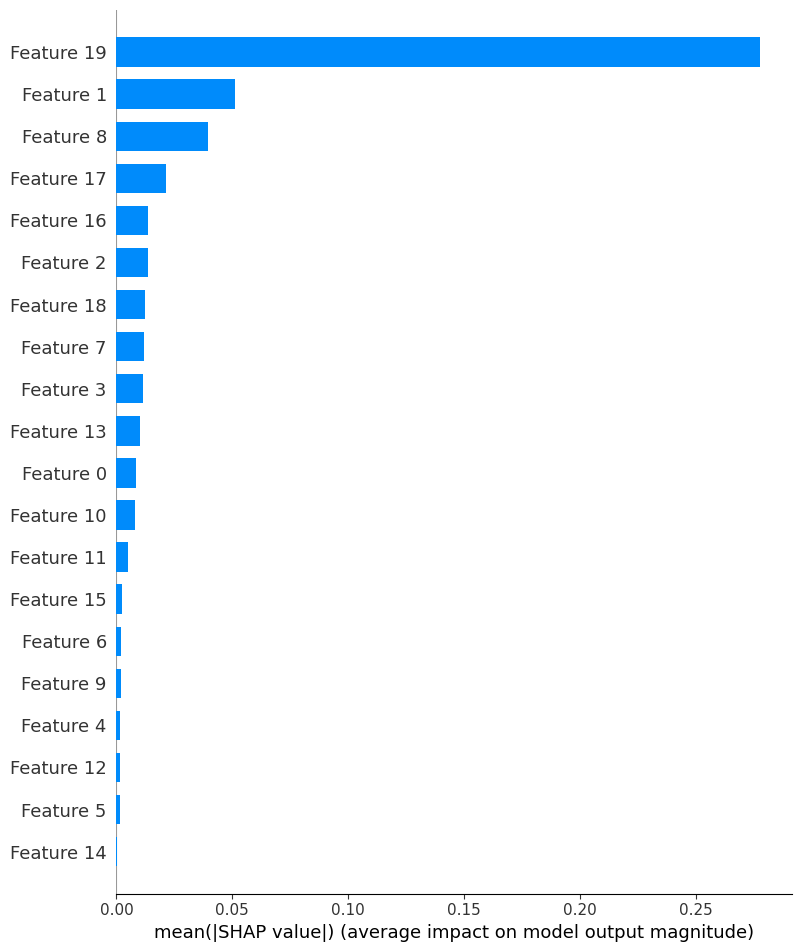

In [ ]:
shap_values_class_0 = shap_values[:, :, 0]  # Extract SHAP values for the first class
shap.summary_plot(shap_values_class_0, X_train_selected, plot_type="bar")


In [ ]:
import os

# List all files in /content
os.listdir('/content')


['.config',
 'UNSW_NB15_testing-set.csv',
 'UNSW_NB15_training-set.csv',
 'sample_data']

In [ ]:
import pandas as pd

# Correct file paths (Replace with actual filenames)
train_file_path = "/content/UNSW_NB15_testing-set.csv"
test_file_path = "/content/UNSW_NB15_training-set.csv"

# Load the datasets
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Display the first few rows
df_train.head(), df_test.head()


(   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
 0   1  0.000011   udp       -   INT      2      0     496       0   
 1   2  0.000008   udp       -   INT      2      0    1762       0   
 2   3  0.000005   udp       -   INT      2      0    1068       0   
 3   4  0.000006   udp       -   INT      2      0     900       0   
 4   5  0.000010   udp       -   INT      2      0    2126       0   
 
           rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
 0   90909.0902  ...                 1               2             0   
 1  125000.0003  ...                 1               2             0   
 2  200000.0051  ...                 1               3             0   
 3  166666.6608  ...                 1               3             0   
 4  100000.0025  ...                 1               3             0   
 
    ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
 0           0                 0           1           2           

In [ ]:
print("Missing values in train dataset:\n", df_train.isnull().sum().sum())
print("Missing values in test dataset:\n", df_test.isnull().sum().sum())


Missing values in train dataset:
 0
Missing values in test dataset:
 0


In [ ]:
print(df_train.info())
print(df_test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [ ]:
# Identify target column (replace 'target_column' with actual name)
target_column = "label"  # Change this to your actual target column name

# Define X (features) and y (target)
X_train = df_train.drop(columns=[target_column])
y_train = df_train[target_column]

X_test = df_test.drop(columns=[target_column])
y_test = df_test[target_column]

# Print shape of datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (82332, 44), y_train shape: (82332,)
X_test shape: (175341, 44), y_test shape: (175341,)


In [ ]:
print(df_train.columns)


Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')


In [ ]:
# Identify non-numeric (categorical) columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_cols)


Categorical Columns: Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


In [ ]:
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure both datasets have the same columns (avoid mismatch issues)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


In [ ]:
print("Columns in X_train:", X_train.columns)
print("Columns in X_test:", X_test.columns)


Columns in X_train: Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=201)
Columns in X_test: Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload',
       ...
       'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS',
       'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic',
       'attack_cat_Normal', 'attack_cat_Reconnaissance',
       'attack_cat_Shellcode', 'attack_cat_Worms'],
      dtype='object', length=201)


In [ ]:
print([col for col in X_train.columns if "proto" in col])


['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'proto_ippc', 'proto_ipv6', 'proto_ipv6-frag', 'proto_ipv6-no', 'proto_ipv6-opts', 'proto_ipv6-route', 'proto_ipx-n-ip', 'proto_irtp', 'proto_isis', 'proto_iso-ip', 'proto_iso-tp4', 'proto_kryptolan', 'proto_l2tp', 'proto_larp', 'proto_leaf-1', 'proto_leaf-2', 'proto_merit-inp', '

In [ ]:
if 'proto' in X_train.columns:
    le = LabelEncoder()
    X_train['proto'] = le.fit_transform(X_train['proto'])
    X_test['proto'] = le.transform(X_test['proto'])
else:
    print("Column 'proto' not found! Check dataset.")


Column 'proto' not found! Check dataset.


In [ ]:
import pandas as pd

df_train = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
df_test = pd.read_csv('/content/UNSW_NB15_training-set.csv')

print(df_train.head())  # Check if 'proto' is present
print(df_test.head())


   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2                0   
1     

In [ ]:
df_train['proto'] = df_train['proto'].astype(str)
df_test['proto'] = df_test['proto'].astype(str)

# One-hot encoding (or label encoding) can be applied here
df_train = pd.get_dummies(df_train, columns=['proto'])
df_test = pd.get_dummies(df_test, columns=['proto'])


In [ ]:
print(df_train.columns)  # Check if 'proto' exists in the training dataset
print(df_test.columns)   # Check if 'proto' exists in the testing dataset


Index(['id', 'dur', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'sttl',
       ...
       'proto_visa', 'proto_vmtp', 'proto_vrrp', 'proto_wb-expak',
       'proto_wb-mon', 'proto_wsn', 'proto_xnet', 'proto_xns-idp', 'proto_xtp',
       'proto_zero'],
      dtype='object', length=175)
Index(['id', 'dur', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'sttl',
       ...
       'proto_visa', 'proto_vmtp', 'proto_vrrp', 'proto_wb-expak',
       'proto_wb-mon', 'proto_wsn', 'proto_xnet', 'proto_xns-idp', 'proto_xtp',
       'proto_zero'],
      dtype='object', length=177)


In [ ]:
proto_columns = [col for col in df_train.columns if col.startswith('proto_')]
print(proto_columns)  # Check the list of proto-related columns


['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'proto_ippc', 'proto_ipv6', 'proto_ipv6-frag', 'proto_ipv6-no', 'proto_ipv6-opts', 'proto_ipv6-route', 'proto_ipx-n-ip', 'proto_irtp', 'proto_isis', 'proto_iso-ip', 'proto_iso-tp4', 'proto_kryptolan', 'proto_l2tp', 'proto_larp', 'proto_leaf-1', 'proto_leaf-2', 'proto_merit-inp', '

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Load the datasets
train_path = "/content/UNSW_NB15_training-set.csv"  # Update if needed
test_path = "/content/UNSW_NB15_testing-set.csv"  # Update if needed

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Drop unnecessary columns
df_train.drop(columns=['id'], inplace=True)
df_test.drop(columns=['id'], inplace=True)

# Define features and target
X_train = df_train.drop(columns=['label', 'attack_cat'])
y_train = df_train['label']
X_test = df_test.drop(columns=['label', 'attack_cat'])
y_test = df_test['label']

# Handle categorical features (skip if already encoded)
categorical_cols = ['service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Ensure train & test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


Final X_train shape: (175341, 62)
Final X_test shape: (82332, 62)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Load datasets
train_path = "/content/UNSW_NB15_training-set.csv"
test_path = "/content/UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Drop unnecessary columns
df_train.drop(columns=['id'], inplace=True, errors='ignore')
df_test.drop(columns=['id'], inplace=True, errors='ignore')

# Convert categorical columns to strings (to avoid mixed types)
df_train = df_train.astype(str)
df_test = df_test.astype(str)

# Encode categorical features using one-hot encoding
categorical_cols = ['proto', 'service', 'state']
df_train = pd.get_dummies(df_train, columns=categorical_cols)
df_test = pd.get_dummies(df_test, columns=categorical_cols)

# Ensure train & test datasets have the same columns
X_train, X_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

# Define target variable
y_train = X_train.pop('label').astype(int)  # Convert label to integer
y_test = X_test.pop('label').astype(int)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_test shape: {X_test.shape}")


Final X_train shape: (175341, 195)
Final X_test shape: (82332, 195)


In [ ]:
# Convert target labels to numerical values
y_train = y_train.astype(str).astype(int)
y_test = y_test.astype(str).astype(int)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load datasets
train_df = pd.read_csv("/content/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("/content/UNSW_NB15_testing-set.csv")

# Define features and target
X_train = train_df.drop(columns=["label", "attack_cat", "id"])  # Drop non-feature columns
y_train = train_df["label"]

X_test = test_df.drop(columns=["label", "attack_cat", "id"])
y_test = test_df["label"]

# Encode categorical target (if needed)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print(y_train[:10])  # Check first 10 values
print(y_train.dtype)  # Ensure it's numeric


[0 0 0 0 0 0 0 0 0 0]
int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_columns = ["proto", "service", "state"]  # Adjust if needed

# Apply Label Encoding with error handling
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()

    # Fit on training data only
    X_train[col] = le.fit_transform(X_train[col])

    # Transform test data safely, assigning unseen values to -1
    X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

    label_encoders[col] = le  # Store encoders if needed for future use

# Verify transformation
print(X_train.head())
print(X_test.head())


        dur  proto  service  state  spkts  dpkts  sbytes  dbytes       rate  \
0  0.121478    113        0      2      6      4     258     172  74.087490   
1  0.649902    113        0      2     14     38     734   42014  78.473372   
2  1.623129    113        0      2      8     16     364   13186  14.170161   
3  1.681642    113        3      2     12     12     628     770  13.677108   
4  0.449454    113        0      2     10      6     534     268  33.373826   

   sttl  ...  ct_dst_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  \
0   252  ...           1                 1                 1               1   
1    62  ...           1                 1                 1               2   
2    62  ...           2                 1                 1               3   
3    62  ...           2                 1                 1               3   
4   254  ...           2                 2                 1              40   

   is_ftp_login  ct_ftp_cmd  ct_flw_http_mth

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
train_path = ('UNSW_NB15_training-set.csv')
test_path = ('UNSW_NB15_testing-set.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Check the first few rows to confirm
print(df_train.head())
print(df_test.head())


   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [ ]:
from sklearn.preprocessing import LabelEncoder

# List categorical columns
categorical_cols = ['proto', 'state', 'service']

# Create a LabelEncoder for each categorical column
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    # Fit on the combined unique values from both train and test sets
    encoders[col].fit(pd.concat([df_train[col], df_test[col]], ignore_index=True).astype(str).unique())
    df_train[col] = encoders[col].transform(df_train[col].astype(str))
    df_test[col] = encoders[col].transform(df_test[col].astype(str))

# Define feature set and target
X_train = df_train.drop(columns=['id', 'attack_cat', 'label'])  # Drop unnecessary columns
y_train = df_train['label']

X_test = df_test.drop(columns=['id', 'attack_cat', 'label'])
y_test = df_test['label']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (175341, 42), y_train shape: (175341,)
X_test shape: (82332, 42), y_test shape: (82332,)


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Use SelectFromModel for faster feature selection
selector = SelectFromModel(rf, threshold="median")  # Select top 50% important features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_src_ltm', 'ct_srv_dst']


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the final model
final_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on selected features
final_model.fit(X_train_selected, y_train)

# Predict on test data
y_pred = final_model.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.8695

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.89      0.87      0.87     82332


Confusion Matrix:
[[27175  9825]
 [  917 44415]]


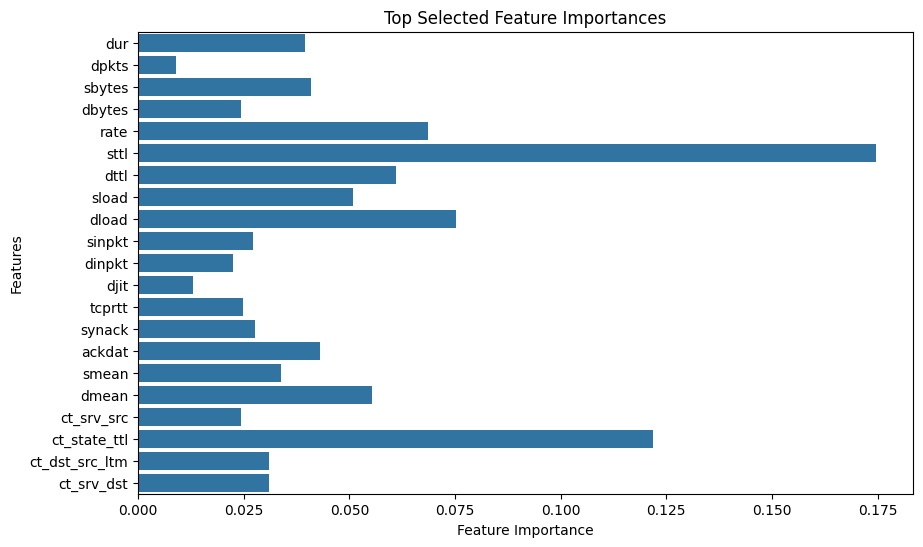

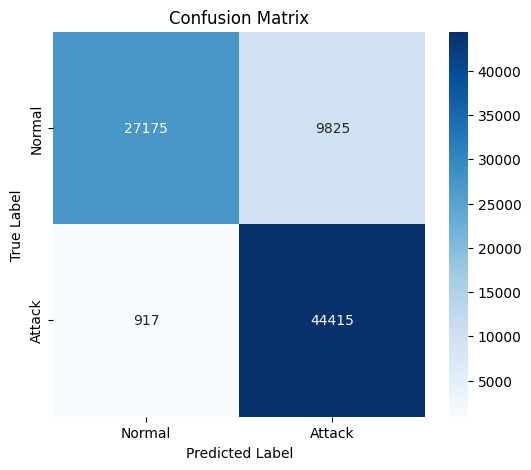

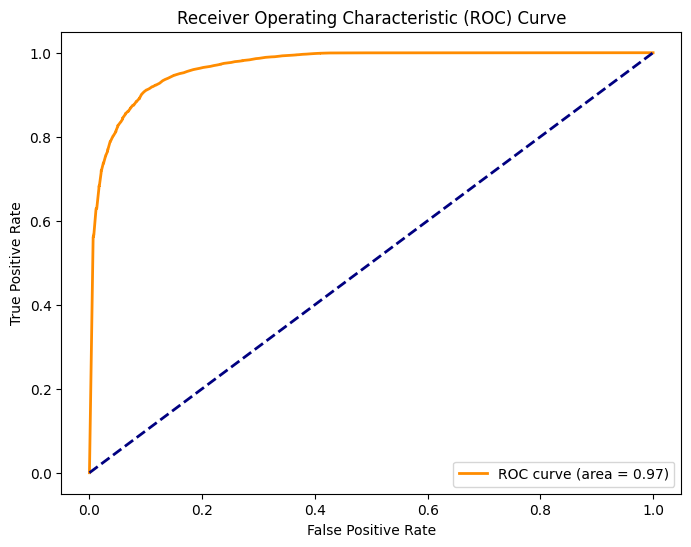

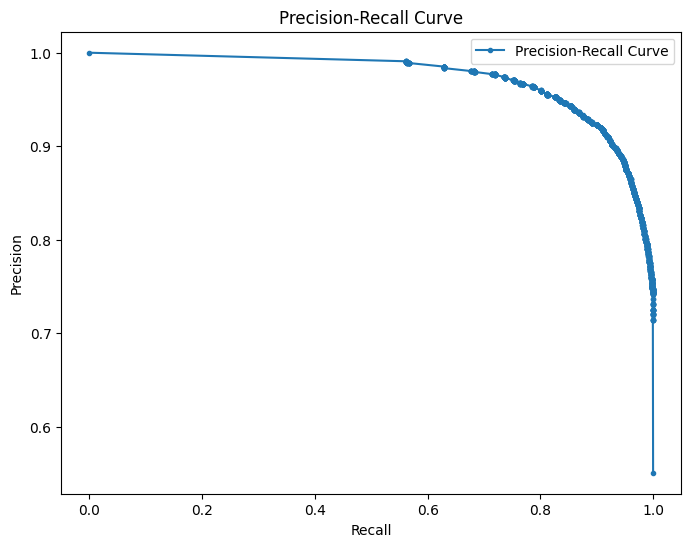

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=final_model.feature_importances_, y=selected_features)  # Use final_model
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top Selected Feature Importances")
plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba) # Remove [:, 1]

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

# Load dataset (assuming preprocessed data with selected features)
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

selected_features = ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_src_ltm', 'ct_srv_dst']
X_train, X_test = df_train[selected_features], df_test[selected_features]
y_train, y_test = df_train['attack_cat'], df_test['attack_cat']

# Train classifiers and track runtime
def train_and_evaluate(model, name):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f'\n{name} Classifier:')
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:\n', report)
    print('Confusion Matrix:\n', cm)
    print(f'Training Time: {end_time - start_time:.2f} seconds')

    return y_pred, acc, cm

# Initialize models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)

# Train & Evaluate
rf_pred, rf_acc, rf_cm = train_and_evaluate(rf, 'Random Forest')
xgb_pred, xgb_acc, xgb_cm = train_and_evaluate(xgb, 'XGBoost')
svm_pred, svm_acc, svm_cm = train_and_evaluate(svm, 'SVM')

# Compare ROC Curves
plt.figure(figsize=(8, 6))
for model, name in zip([rf, xgb, svm], ['Random Forest', 'XGBoost', 'SVM']):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()



Random Forest Classifier:
Accuracy: 0.7645
Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.02      0.02      0.02       677
      Backdoor       0.08      0.09      0.08       583
           DoS       0.60      0.12      0.19      4089
      Exploits       0.60      0.84      0.70     11132
       Fuzzers       0.29      0.61      0.39      6062
       Generic       1.00      0.97      0.98     18871
        Normal       0.96      0.76      0.84     37000
Reconnaissance       0.88      0.80      0.84      3496
     Shellcode       0.32      0.60      0.41       378
         Worms       0.56      0.32      0.41        44

      accuracy                           0.76     82332
     macro avg       0.53      0.51      0.49     82332
  weighted avg       0.83      0.76      0.78     82332

Confusion Matrix:
 [[   12    23     6   375   196     0    61     1     3     0]
 [   10    51     6   263   211     0    32     3     7     0]


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7 8 9], got ['Analysis' 'Backdoor' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:16:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest Accuracy: 0.8695
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.89      0.87      0.87     82332



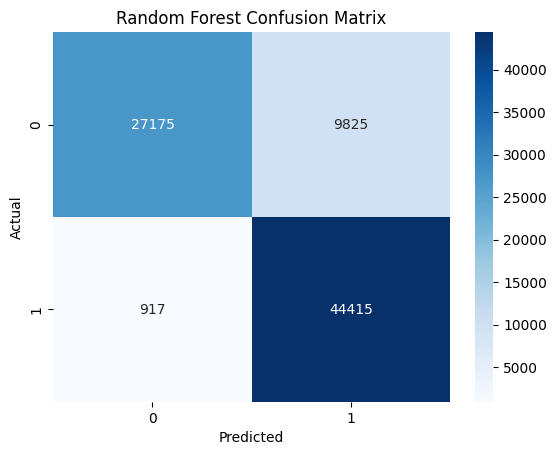

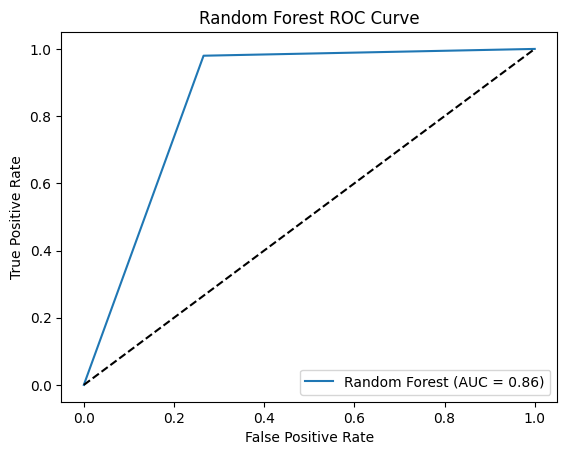


SVM Accuracy: 0.7549
              precision    recall  f1-score   support

           0       0.91      0.51      0.65     37000
           1       0.70      0.96      0.81     45332

    accuracy                           0.75     82332
   macro avg       0.81      0.73      0.73     82332
weighted avg       0.80      0.75      0.74     82332



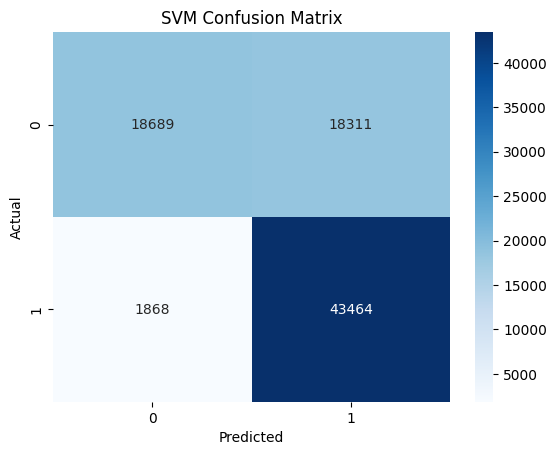

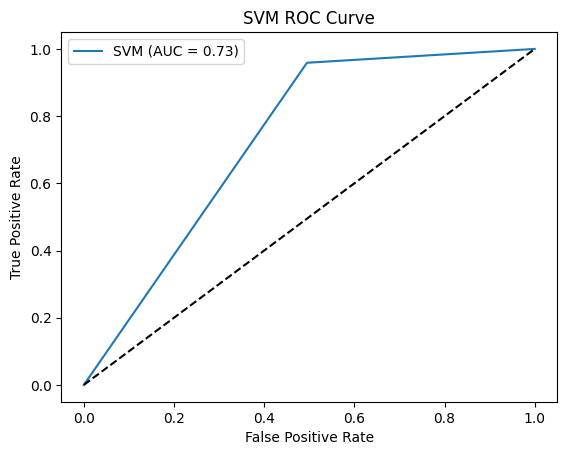


XGBoost Accuracy: 0.8684
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.86     82332
weighted avg       0.88      0.87      0.87     82332



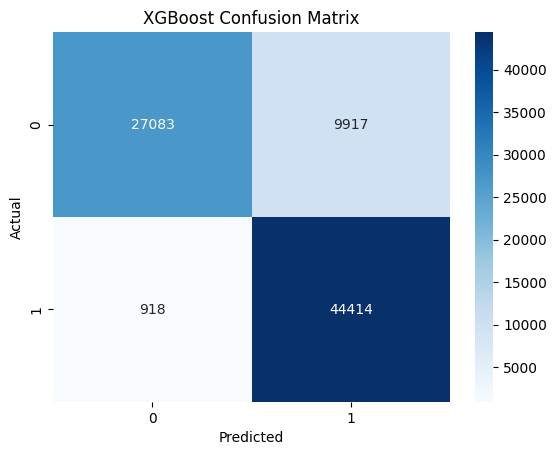

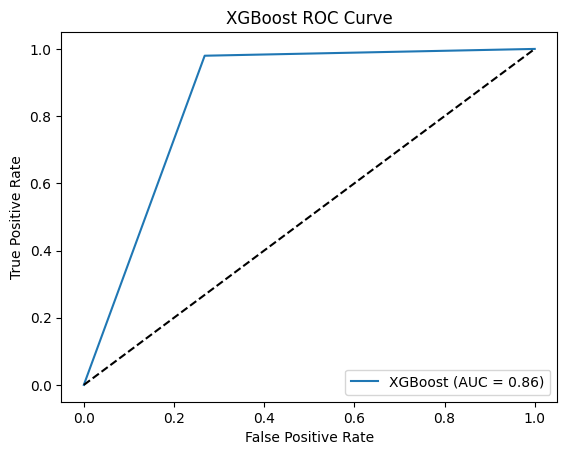

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

# Load dataset
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Define features and target
features = ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_src_ltm', 'ct_srv_dst']
# Change 'attack_label' to the actual target column name in your dataset
target = 'label'  # Or 'attack_cat' if that's your target column

X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train[target], df_test[target]

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = LinearSVC(dual=False, max_iter=5000)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train classifiers
rf.fit(X_train, y_train)
svm.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

# Compare models
evaluate_model(y_test, y_pred_rf, 'Random Forest')
evaluate_model(y_test, y_pred_svm, 'SVM')
evaluate_model(y_test, y_pred_xgb, 'XGBoost')

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# Optimized XGBoost model
xgb_optimized = XGBClassifier(
    n_estimators=300,        # More trees for better learning
    learning_rate=0.05,      # Slower learning for higher accuracy
    max_depth=8,             # Slightly deeper trees
    subsample=0.8,           # Uses 80% of data per tree to avoid overfitting
    colsample_bytree=0.8,    # Uses 80% of features per tree
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Train model and measure time
start_time = time.time()
xgb_optimized.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred_xgb_opt = xgb_optimized.predict(X_test)

# Evaluate performance
accuracy_xgb_opt = accuracy_score(y_test, y_pred_xgb_opt)
print(f"Optimized XGBoost Accuracy: {accuracy_xgb_opt:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_opt))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_opt))

print(f"\nTraining Time: {end_time - start_time:.2f} seconds")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimized XGBoost Accuracy: 0.8718

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332


Confusion Matrix:
[[27236  9764]
 [  792 44540]]

Training Time: 16.91 seconds


# **visualizations for the optimized XGBoost model**

---



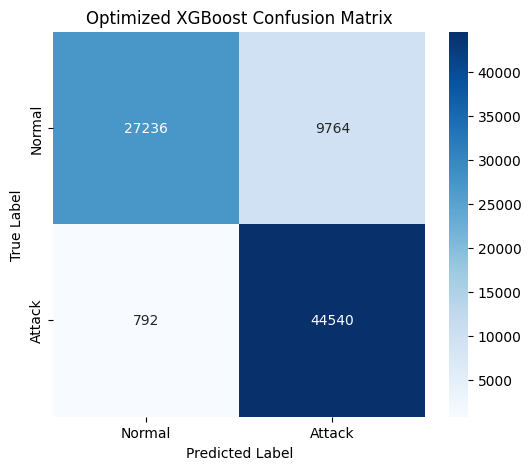

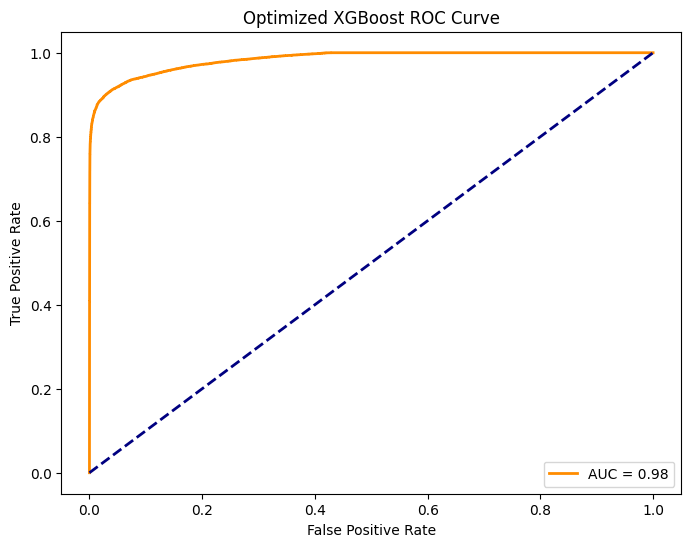

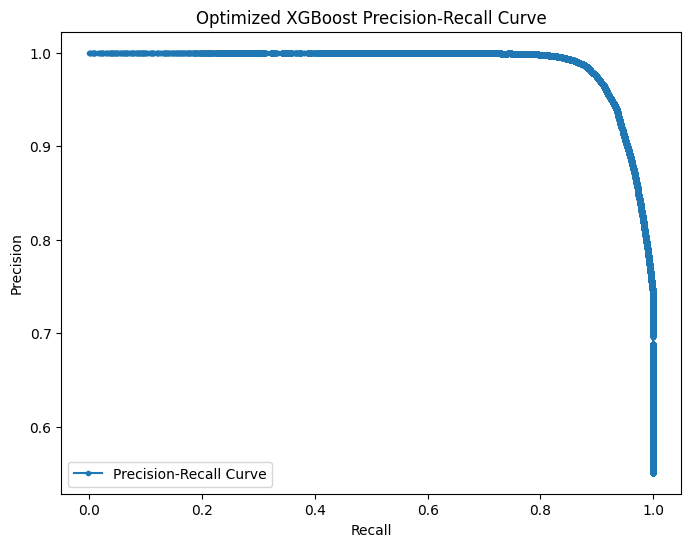

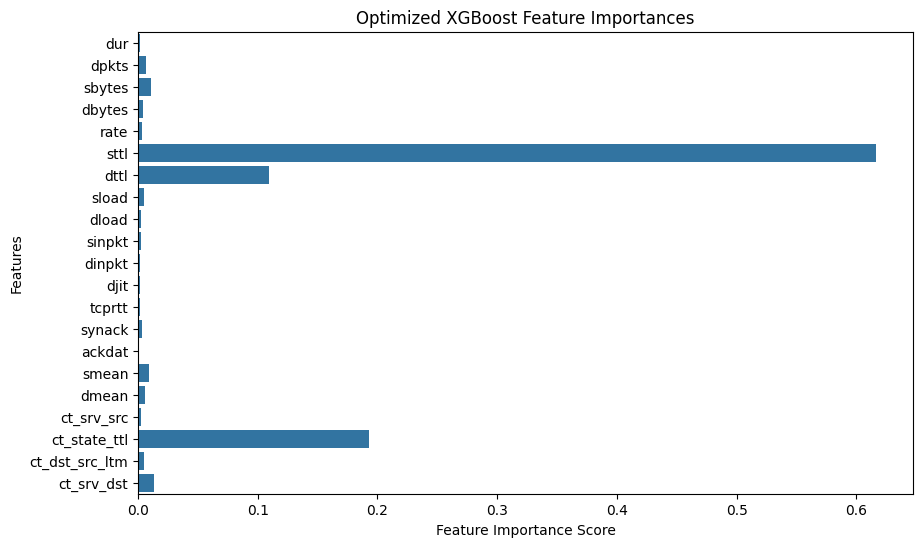

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# 1️⃣ Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_xgb_opt)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized XGBoost Confusion Matrix")
plt.show()

# 2️⃣ ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_optimized.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Optimized XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3️⃣ Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, xgb_optimized.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker=".", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Optimized XGBoost Precision-Recall Curve")
plt.legend()
plt.show()

# 4️⃣ Feature Importance Bar Chart
selected_features = ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_src_ltm', 'ct_srv_dst']
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_optimized.feature_importances_, y=selected_features)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Optimized XGBoost Feature Importances")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Load dataset
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Define features and target
features = ['dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sinpkt', 'dinpkt', 'djit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_src_ltm', 'ct_srv_dst']
# Change 'attack_label' to the actual target column name in your dataset
target = 'label'  # Or 'attack_cat' if that's your target column

X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train[target], df_test[target]

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Step 1: Feature Selection (Top N features from XGBoost)
top_features = ['sttl', 'ct_srv_src', 'ct_state_ttl', 'dttl']  # Adjust based on feature importance
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Step 2: Use PCA for further dimensionality reduction (optional)
pca = PCA(n_components=min(len(top_features), 2))  # Reduce to 2 principal components

# Step 3: Fast SVM Training Pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', pca),  # Reduce dimensions
    ('svm', SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, n_jobs=-1))  # Fast SVM
])

# Train the model
svm_pipeline.fit(X_train_selected, y_train)

# Evaluate the model
svm_predictions = svm_pipeline.predict(X_test_selected)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Optimized SVM Accuracy: {svm_accuracy:.4f}")

Optimized SVM Accuracy: 0.7662


In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train are defined from previous steps

# Initialize and train an XGBoost model first
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Now use the trained xgb_model in SelectFromModel
selector = SelectFromModel(xgb_model, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train a fast Linear SVM
svm_model = LinearSVC(max_iter=10000, dual=False)
svm_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized SVM Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:56:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Optimized SVM Accuracy: 0.6493
